In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
from matplotlib import collections  as mc

In [ ]:
#getting started https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

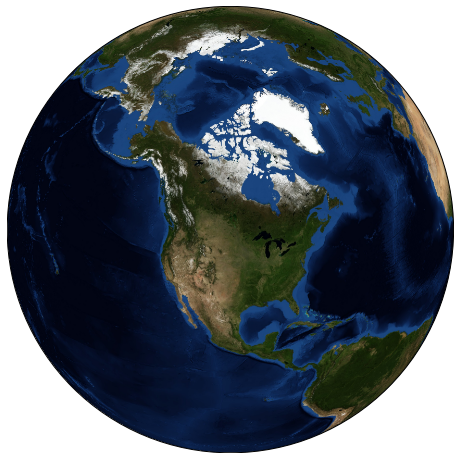

In [41]:
plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
m.bluemarble(scale=0.5);

## Read and combine files, convert coordinates to floats, calculate bounding box

In [3]:
#read in points from file
df1 = pd.read_csv('../data/raw/IBS2_First_2_Years/Tow_Info.csv')
df2 = pd.read_csv('../data/raw/IBS2_First_2_Years/tow_info_201880.csv')
tow_df = df1.append( df2, ignore_index=True ).dropna()

tow_df['slon'] =  tow_df.apply(lambda row: float((row["START_LON"]).replace('W','')) / -100, axis=1) 
tow_df['slat'] =  tow_df.apply(lambda row: float((row["START_LAT"]).replace('N','')) / 100, axis=1) 
tow_df['elon'] =  tow_df.apply(lambda row: float((row["END_LON"]).replace('W','')) / -100, axis=1) 
tow_df['elat'] =  tow_df.apply(lambda row: float((row["END_LAT"]).replace('N','')) / 100, axis=1) 
tow_df['pdate'] = tow_df.apply(lambda row: pd.to_datetime( row['START_TIME'] ), axis=1 ) 

lats = [ i for i in tow_df['slat'] ]
lons = [ i for i in tow_df['slon'] ]

llcrnrlon = min(lons)
llcrnrlat = min(lats)
urcrnrlon = max(lons)
urcrnrlat = max(lats)
box = [ llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat ]
print(box)


[-70.513639999999995, 41.479089999999999, -69.302949999999996, 43.438689999999994]


#### distribution of tows distances, remove erroneous data

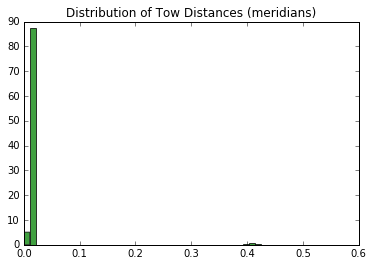

In [44]:
tow_df['dist'] = ((tow_df['slon'] - tow_df['elon'])**2 + (tow_df['slat'] - tow_df['elat'])**2) ** 0.5
(min(tow_df['dist']), max(tow_df['dist']), sum(tow_df['dist'])/len(tow_df['dist'])  )

plt.hist(tow_df['dist'], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('Distribution of Tow Distances (meridians)')
plt.savefig( '../data/raw/Tow_Distance_hist.png' )
plt.show()


In [45]:
#drop erroneous long tows
print( tow_df.size )
tow_df = tow_df.loc[tow_df['dist'] < .1]
print( tow_df.size )

13584
13360


In [22]:
for i, r in tow_df.iterrows():
    
    try:
        pass
        #print( pd.to_datetime(r['START_TIME']  ) )
    except:
        print( r['START_TIME'] )
#type(tow_df['START_TIME'])
# tow_df['date_parse'] = tow_df['START_TIME'].to_datetime()

In [46]:
def get_arc( row ):
    return ( 
        row['slon'], row['slat'], row['elon'], row['elat'] )

In [35]:
#explore dates
#for index, row in tow_df.iterrows():
#    print( row['pdate'].to_datetime().month )

for month in range(1,13):
    print(month)

1
2
3
4
5
6
7
8
9
10
11
12


### plot all tows

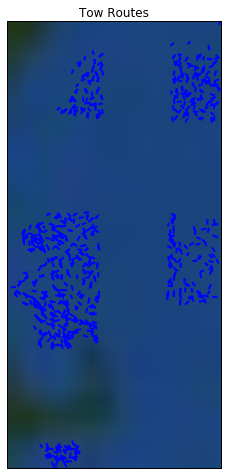

In [20]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='cass', resolution='i', llcrnrlon=box[0], llcrnrlat=box[1],
            urcrnrlon=box[2], urcrnrlat=box[3], 
            width=8E6, height=8E6, 
            lat_0=43.260511, lon_0=-68.299058,)  #43.260511, -68.299058
m.bluemarble()
#m.drawcoastlines()

# Map (long, lat) to (x, y) for plotting
#plt.plot()

for index, row in tow_df.iterrows():
    try:
        arc = get_arc(row)
        
        m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='b')
    except:
        pass

#x, y = m(lons, lats)
#plt.plot(x, y, 'ok', markersize=5)
plt.title('Tow Routes')

plt.savefig( '../data/raw/Tow_Routes_zoomin.png' )
#plt.text(x, y, ' Seattle', fontsize=12);
plt.show()

### plot tows by month

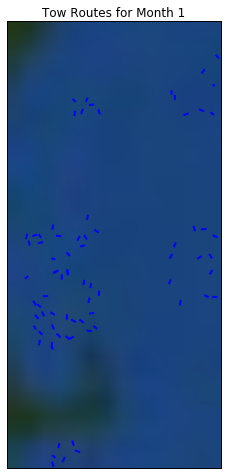

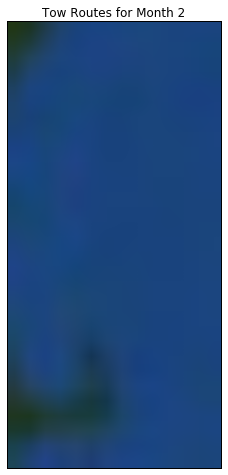

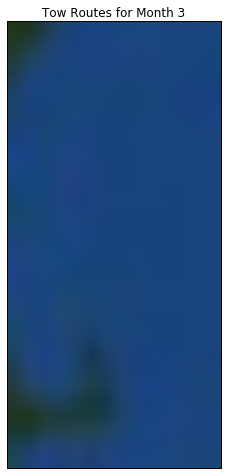

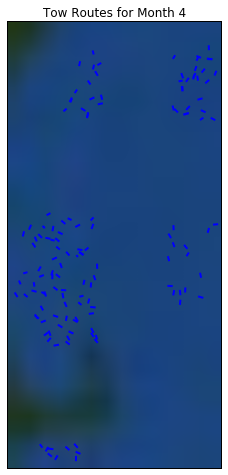

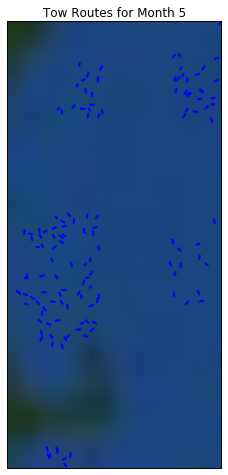

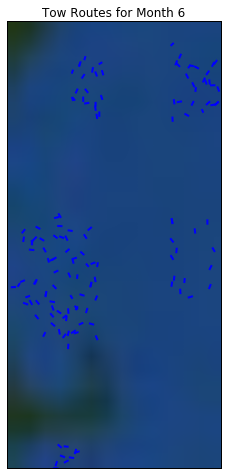

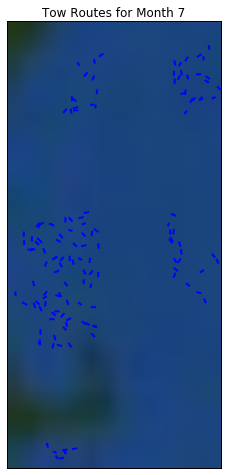

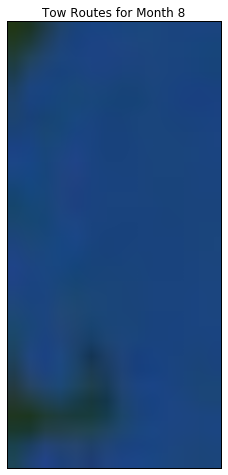

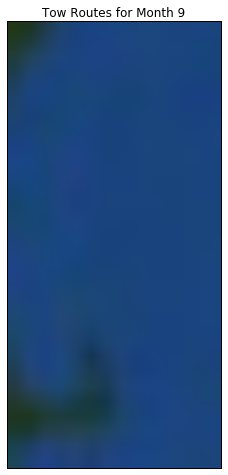

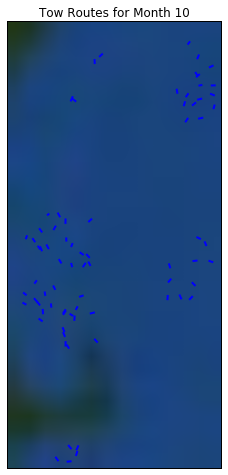

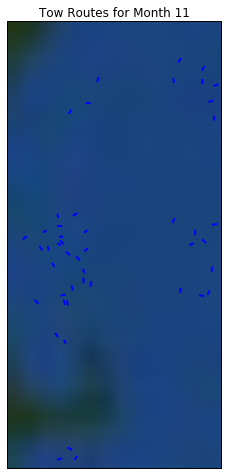

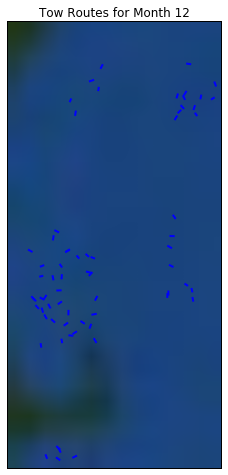

In [48]:
#Color by month
#m.drawcoastlines()
# Map (long, lat) to (x, y) for plotting
#plt.plot()

for this_month in range(1,13):
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='cass', resolution='i', llcrnrlon=box[0], llcrnrlat=box[1],
                urcrnrlon=box[2], urcrnrlat=box[3], 
                width=8E6, height=8E6, 
                lat_0=43.260511, lon_0=-68.299058,)  #43.260511, -68.299058
    m.bluemarble()
    counter = 0
    for index, row in tow_df.iterrows():
        
        if row['pdate'].to_datetime().month == this_month:
            try:
                arc = get_arc(row)
                m.drawgreatcircle(arc[0],arc[1],arc[2],arc[3],linewidth=2,color='b')
            except:
                raise ValueError('A very specific bad thing happened.')
                
    #print( 'month', this_month )

    plt.title('Tow Routes for Month {0}'.format(this_month) )
    plt.savefig( '../data/raw/month_routes/Tow_Routes_month{0}.png'.format(this_month) )
#     plt.show()

### distribution of tows by month

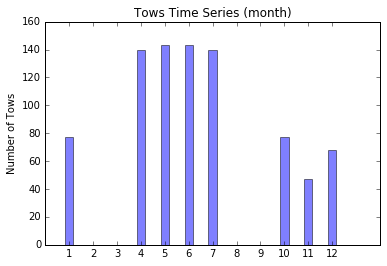

In [68]:
#show dist of tows in calendar year
y_pos = np.arange(1,13)
tows = []
for this_month in range(1,13):
    tows.append( len([ i.to_datetime().month for i in tow_df['pdate'] if i.to_datetime().month == this_month]))
plt.bar(y_pos, tows, bar_width, align='center', alpha=0.5)
plt.xticks(y_pos, y_pos)
plt.ylabel('Number of Tows')
plt.title('Tows Time Series (month)')
plt.savefig( '../data/raw/month_routes/Tow_month_distribution.png')
plt.show()